In [1]:
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
from sys import stdout
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

In [253]:
pdb = PDBFile('proteins/6ct4.pdb')
forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')
modeller = Modeller(pdb.topology, pdb.positions)

system = forcefield.createSystem(modeller.topology, nonbondedMethod=CutoffNonPeriodic, nonbondedCutoff=1*nanometer, constraints=HBonds)
integrator = LangevinIntegrator(300*kelvin, 1/picosecond, 0.002*picoseconds)
simulation = Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)
simulation.minimizeEnergy()

In [256]:
class AA:
    def __init__(self, residue, context):
        self.context = context
        self.residue = residue
        self.atoms = list(self.residue.atoms())
        self.atoms_dict = {atom.name:atom.index for atom in self.atoms}
        self.atom_indices = list(self.atoms_dict.values())
        self.backbone_names = ['N', 'H', 'CA', 'HA', 'C', 'O', 'H2', 'H3', 'OXT']
        
    def _get_atom_pos(self):
        return self.context.getState(getPositions=True).getPositions(asNumpy=True)
    
    def get_atom_pos(self, positions=None):
        if positions is None:
            positions = self._get_atom_pos()
        return positions[self.atom_indices]
    
    def get_pos(self, positions=None):
        if positions is None:
            positions = self._get_atom_pos()
        return positions[self.atoms_dict['CA']]
        
    def get_backbone_dir(self, positions=None):
        if positions is None:
            positions = self._get_atom_pos()
        backbone_dir = positions[self.atoms_dict['C']] - positions[self.atoms_dict['N']]
        return backbone_dir / np.sqrt(np.sum(backbone_dir ** 2))
        
    def get_avg_side_chain_pos(self, positions=None):
        if positions is None:
            positions = self._get_atom_pos()
        indices = [atom.index for atom in self.atoms if atom.name not in self.backbone_names]
        return positions[indices].mean(axis=0)
    
    def get_side_chain_dir(self, positions=None):
        if positions is None:
            positions = self._get_atom_pos()
        side_chain_dir = self.get_avg_side_chain_pos(positions) - self.get_pos(positions)
        return side_chain_dir / np.sqrt(np.sum(side_chain_dir ** 2))
    
    def get_amino_pos(self, positions=None):
        if positions is None:
            positions = self._get_atom_pos()
        return positions[self.atoms_dict['N']]
    
    def get_carboxyl_pos(self, positions=None):
        if positions is None:
            positions = self._get_atom_pos()
        return positions[self.atoms_dict['C']]
    
    def set_pos(self, pos):
        positions = self._get_atom_pos()
        positions[self.atom_indices] += -self.get_pos(positions) + np.array(pos) * nanometers
        self.context.setPositions(positions)
            
chain = []
for i, residue in enumerate(simulation.topology.residues()):
    aa = AA(residue, simulation.context)
    chain.append(aa)

<IPython.core.display.Javascript object>


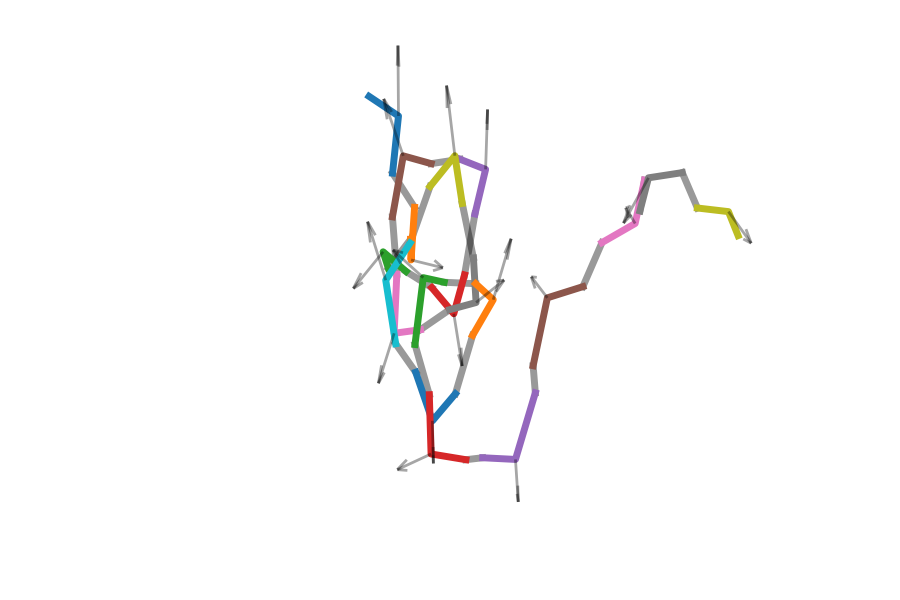

In [287]:
def plot(aas, all_atoms=False, side_chains=True, aa_connections=True, aa_backbones=True):
    def as_array(fun):
        return np.array([fun(aa)._value for aa in aas])
    
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    if all_atoms:
        positions = as_array(AA.get_atom_pos)
        for pos in positions:
            ax.plot(pos[:,0], pos[:,1], pos[:,2], '.', alpha=0.1)
    
    if side_chains:
        pos = as_array(AA.get_pos)
        side_chain_dir = as_array(AA.get_side_chain_dir) * 0.15
        ax.quiver(pos[:,0], pos[:,1], pos[:,2], side_chain_dir[:,0], side_chain_dir[:,1], side_chain_dir[:,2],
                  colors='black', alpha=0.35, linewidth=2)
    
    if aa_connections:
        for i in range(1, len(aas)):
            points = np.array([aas[i-1].get_carboxyl_pos()._value, aas[i].get_amino_pos()._value])
            ax.plot(points[:,0], points[:,1], points[:,2], c='black', alpha=0.4, linewidth=5)
    
    if aa_backbones:
        for aa in aas:
            points = np.array([aa.get_amino_pos()._value, aa.get_pos()._value, aa.get_carboxyl_pos()._value])
            ax.plot(points[:,0], points[:,1], points[:,2], linewidth=5)
    
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plot(chain)